# Generate Figure 4 for Kaiser et al. 2020 (The Spite Plot)

This is the same message at the beginning of all jupyter notebooks in this directory. 

If you don't have the below packages, you obviously need to install them for this to work. If it doesn't work still it's extremely likely you have an outdated version of one of the packages. Alternatively, some of the histogram functions actually rely on not being the most recent version because they changed from "normed" to something else from my recollection. Or perhaps it was the other way. I am aware this was poor decision-making, but it works (if you use the right version). ¯\\_(ツ)_/¯

Also pretty much all of these commands are copied and pasted from another Jupyter notebook I made but contained tons of tries at doing this stuff (and unrelated efforts) so that's why a lot of the variables seem unnecessary to use.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from astropy.io import fits
from glob import glob
from astropy.time import Time
from astropy import coordinates as coords
from astropy import units as u
from astropy import constants as const
from astropy import convolution as conv
from astropy.table import Table, Column
import scipy.interpolate as scinterp
import time
start = time.time()

import spec_plot_tools as spt
import cal_params as cp
import plot_spec as ps
import bensby_plotting as bp

print(os.getcwd())



no file_setting specificied


/Users/BenKaiser/Desktop/abd1714_Kaiser_et_al_2020_Science


In [2]:
target_dir= '/Users/BenKaiser/Desktop/GaiaJ1644m0449_paper/'
os.chdir(target_dir)

In [3]:
wd_abund_file='temp_wd_abundances.csv'
lodders_abund_file='Lodders2009_solarsystem_abundances.csv'

In [4]:
wd_abund_table=Table.read(wd_abund_file)
wd_abund_table.add_index('name')

In [5]:
lodders_table=Table.read(lodders_abund_file)
lodders_table.add_index('element')

In [37]:
color_dict={
    'GaiaJ1644-0449':'#ff0000',
    'SDSSJ1330+6435':'#8900ff',
    'WDJ2356-209':'#00ffc5'#'#b0ff00'
}

fill_dict={
    'GaiaJ1644-0449':'#ffc3c3',#'#ff8282',
    'SDSSJ1330+6435':'#d0a3ff',#'#c689fb',
    'WDJ2356-209':'#ebfffb'#'#d4fb7e'
}
step_dict={
    'GaiaJ1644-0449':10,
    'SDSSJ1330+6435':0.1,
    'WDJ2356-209':10
}


line_dict={
    'thin': ':',
    'thick':'-',
    'halo':'-.'
}

wd_marker='*'
met_marker='D'
met_color='#1ca1f2'
ci_size=14
wd_size=14
dp_alpha=1
arr_naca=[-0.4,-0.1]


star_marker='o'
pop_colors=['darkorange','brown','navy','grey'] #thin disk, thick disk, halo, in-between for Bensby plots

spite_alpha=1



In [24]:
def LiHe_to_ALi(row,CaFe, FeH, phase='EP'):
    LiCa= row['li/he']-row['ca/he'] #general number, not relative to solar
    if phase=='EP':
        pass
    elif phase=='SSP':
        LiCa=LiCa+row['tau_ca/tau_li']
    #print('Li/Ca', LiCa)
    CaH=CaFe+FeH #relative to solar
    #print('[Ca/H]', CaH)
    #print('lodders A(Ca)',lodders_table['A_el'][np.where(lodders_table['element']=='Ca')])
    CaH=CaH+lodders_table['A_el'][np.where(lodders_table['element']=='Ca')] #CaH now in A(Ca)
    #print('A(Ca)', CaH)
    LiH=LiCa+CaH #puts LiH immediately on the A(Li) scale
    ALi= LiH
    return ALi

In [25]:
def make_dist(value,sigma, npoints):
    return np.random.normal(loc=value, scale=sigma, size=npoints )




In [26]:
#from Mashonkina et al. 2019 and the other Mashonkina et al. 2019/2020 paper that included thin disk stars as well.
npoints=100
FeH_thick= np.linspace(-1.5,-0.4,npoints)
FeH_halo=np.linspace(-2.6,-1.2,npoints)
FeH_thin= np.linspace(-0.73, 0.24, npoints)
#from Mashonkina et al. 2019
CaFe_thick=0.24
CaFe_thick_err=0.07
CaFe_halo=0.35
CaFe_halo_err=0.08

#from later Mashonkina et al. 2019/2020 and our by-eye approximation of the trend
def get_CaFe_thin(FeH):
    slope=(0-0.24)/(0+0.7)
    print(slope)
    return slope*FeH

CaFe_thin=get_CaFe_thin(FeH_thin)

-0.34285714285714286


In [27]:
#grisoni_primordial=2.6
grisoni_ALi=2.6
coc_ALi=2.7
primordial_ALi=coc_ALi
def grisoni_crude(FeH):
    """
    return the A(Li) value for the [Fe/H] value using Grisoni et al. 2019 approximated model
    """
    flat_inds= np.where(FeH< -0.71)
    func_inds= np.where(FeH>= -0.71)
    output_array=np.ones(FeH.shape)
    output_array[flat_inds]= primordial_ALi
    output_array[func_inds]= 1.111*(FeH[func_inds]+0.71)+primordial_ALi
    return output_array

In [28]:
ymin=0
ymax=5
def make_plot():
    plt.errorbar(0, lodders_table.loc['Li']['A_el'], yerr=lodders_table.loc['Li']['A_el_err'], label='CI Chond.', marker=met_marker,color=met_color, markersize=ci_size)
    model_FeH= np.linspace(-3, 0.6, 100)
    model_ALi= grisoni_crude(model_FeH)
    plt.plot(model_FeH, model_ALi, label='Crude Grisoni et al. 2019', linestyle='--', color='k')
    plt.xlabel('[Fe/H]')
    plt.ylabel('A(Li)')
    #plt.legend(loc='best')
    plt.xlim(-3, 0.6)
    plt.ylim(ymin,ymax)
    plt.show()
    return

In [29]:
def fill_under(FeH, ALi_hi,wd_name,ALi_lo=ymin):
    #plt.fill_between(FeH, ALi_hi, ALi_lo, color=color_dict[wd_name], alpha=spite_alpha)
    plt.fill_between(FeH, ALi_hi, ALi_lo, color=fill_dict[wd_name])
    return

There's no [Fe/H] error for the meteor because it is defined to be 0 as the solar value, so it can't have an uncertainty really...

-0.34285714285714286
0.21199191185590077 0.3839391892211057
       B_ALi        
--------------------
0.030000000000000027
 0.10000000000000009
 0.06000000000000005
 0.06000000000000005
 0.04999999999999982
 0.06000000000000005
 0.04999999999999982
                  --
0.039999999999999813
0.050000000000000266
                 ...
 0.06000000000000005
0.040000000000000036
                  --
0.040000000000000036
 0.06000000000000005
                  --
0.040000000000000036
 0.08999999999999986
                  --
                  --
                0.06
Length = 714 rows
<class 'astropy.table.column.MaskedColumn'>
<class 'astropy.table.column.MaskedColumn'>
ALi.shape (714,)
0.19732206016716017 0.37619618658287


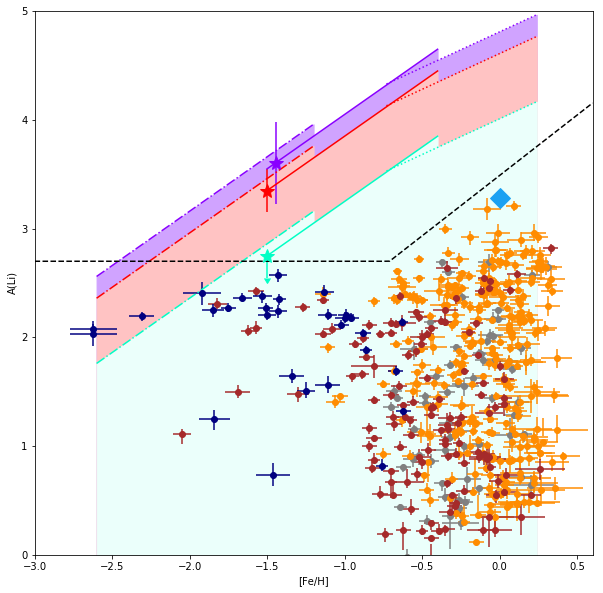

In [38]:
n_random=1000
#j1644_LiCa_dist=make_dist(wd_abund_table.loc['GaiaJ1644-0449']['li/ca'],wd_abund_table.loc['GaiaJ1644-0449']['li/ca_err'], n_random)
#j1330_LiCa_dist=make_dist(wd_abund_table.loc['SDSSJ1330+6435']['li/ca'],wd_abund_table.loc['SDSSJ1330+6435']['li/ca_err'], n_random)
#j1330_LiCa_dist=make_dist(j1330_LiCa_DP,wd_abund_table.loc['SDSSJ1330+6435']['li/ca_err'], n_random)

wd_list=[
    'SDSSJ1330+6435',
    'GaiaJ1644-0449',
    'WDJ2356-209',
]

pop_list=[
    'thin',
    'thick',
    'halo'
]
def plot_wd_ALi(wd_name, pop):
    wd_lica_ep=wd_abund_table.loc[wd_name]['li/ca']
    if pop=='thin':
        wd_ALi_vals=wd_lica_ep+(CaFe_thin+FeH_thin)+lodders_table.loc['Ca']['A_el']
        plt.plot(FeH_thin, wd_ALi_vals,  color=color_dict[wd_name], linestyle=line_dict[pop])
        fill_under(FeH_thin, wd_ALi_vals, wd_name)
    elif pop=='thick':
        wd_ALi_vals=wd_lica_ep+(CaFe_thick+FeH_thick)+lodders_table.loc['Ca']['A_el']
        plt.plot(FeH_thick, wd_ALi_vals,  color=color_dict[wd_name], linestyle=line_dict[pop])
        fill_under(FeH_thick, wd_ALi_vals, wd_name)
    elif pop=='halo':
        wd_ALi_vals=wd_lica_ep+(CaFe_halo+FeH_halo)+lodders_table.loc['Ca']['A_el']
        plt.plot(FeH_halo, wd_ALi_vals,  color=color_dict[wd_name], linestyle=line_dict[pop])
        fill_under(FeH_halo, wd_ALi_vals, wd_name)
    return



j1644_LiCa_dist=make_dist(wd_abund_table.loc['GaiaJ1644-0449']['li/ca'],wd_abund_table.loc['GaiaJ1644-0449']['li/ca_err'], n_random)
j1330_LiCa_dist=make_dist(wd_abund_table.loc['SDSSJ1330+6435']['li/ca'],wd_abund_table.loc['SDSSJ1330+6435']['li/ca_err'], n_random)


CaFe_dist=make_dist(get_CaFe_thin(FeH_thin[-1]), 0.1, n_random)
ACa_dist=make_dist(lodders_table.loc['Ca']['A_el'], lodders_table.loc['Ca']['A_el_err'],n_random)


j1330_ALi_vals=wd_abund_table.loc['SDSSJ1330+6435']['li/ca']+(CaFe_thin+FeH_thin)+lodders_table.loc['Ca']['A_el']
j1644_ALi_vals= wd_abund_table.loc['GaiaJ1644-0449']['li/ca']+(CaFe_thin+FeH_thin)+lodders_table.loc['Ca']['A_el']



j1644_ALi_dist=j1644_LiCa_dist+CaFe_dist+FeH_thin[-1]+ACa_dist
j1330_ALi_dist=j1330_LiCa_dist+CaFe_dist+FeH_thin[-1]+ACa_dist
j1644_ALi_err= np.std(j1644_ALi_dist)
j1330_ALi_err= np.std(j1330_ALi_dist)
print(j1644_ALi_err, j1330_ALi_err)

plt.figure(figsize=(10,10))

for wd in wd_list:
    for pop in pop_list:
        plot_wd_ALi(wd,pop)

bp.plot_ALi_FeH(colors=pop_colors, marker=star_marker)

#plt.plot(FeH_thin,j1330_ALi_vals ,  color=color_dict['SDSSJ1330+6435'], linestyle=line_dict['thin'])
#plt.errorbar(FeH_thin[8], j1330_ALi_vals[8], yerr=j1330_ALi_err, color='r',label=wd_abund_table.loc['SDSSJ1330+6435']['name']+' thin disk EP',marker='o')


#plt.plot(FeH_thin, j1644_ALi_vals,  color=color_dict['GaiaJ1644-0449'], linestyle=line_dict['thin'])
#fill_under(FeH_thin, j1644_ALi_vals, 'GaiaJ1644-0449')
#plt.errorbar(FeH_thin[3], j1644_ALi_vals[3], yerr=j1644_ALi_err, color='b',label=wd_abund_table.loc['GaiaJ1644-0449']['name']+' thin disk EP', marker='o')

###########

CaFe_dist=make_dist(CaFe_thick, CaFe_thick_err, n_random)
ACa_dist=make_dist(lodders_table.loc['Ca']['A_el'], lodders_table.loc['Ca']['A_el_err'],n_random)


j1330_ALi_vals=wd_abund_table.loc['SDSSJ1330+6435']['li/ca']+(CaFe_thick+FeH_thick)+lodders_table.loc['Ca']['A_el']
j1644_ALi_vals= wd_abund_table.loc['GaiaJ1644-0449']['li/ca']+(CaFe_thick+FeH_thick)+lodders_table.loc['Ca']['A_el']



j1644_ALi_dist=j1644_LiCa_dist+CaFe_dist+FeH_thick[-1]+ACa_dist
j1330_ALi_dist=j1330_LiCa_dist+CaFe_dist+FeH_thick[-1]+ACa_dist
j1644_ALi_err= np.std(j1644_ALi_dist)
j1330_ALi_err= np.std(j1330_ALi_dist)
print(j1644_ALi_err, j1330_ALi_err)

#plt.plot(FeH_thick,j1330_ALi_vals ,  color=color_dict['SDSSJ1330+6435'], linestyle=line_dict['thick'])
plt.errorbar(FeH_thick[5], j1330_ALi_vals[5], label=wd_abund_table.loc['SDSSJ1330+6435']['name']+' thick disk EP',yerr=j1330_ALi_err, color=color_dict['SDSSJ1330+6435'],marker=wd_marker, markersize=wd_size)


#plt.plot(FeH_thick, j1644_ALi_vals,  color=color_dict['GaiaJ1644-0449'], linestyle=line_dict['thick'])
plt.errorbar(FeH_thick[0], j1644_ALi_vals[0],label=wd_abund_table.loc['GaiaJ1644-0449']['name']+' thick disk EP', yerr=j1644_ALi_err, color=color_dict['GaiaJ1644-0449'], marker=wd_marker, markersize=wd_size)
#fill_under(FeH_thick, j1644_ALi_vals, 'GaiaJ1644-0449')



j1330_ALi_vals=wd_abund_table.loc['SDSSJ1330+6435']['li/ca']+(CaFe_halo+FeH_halo)+lodders_table.loc['Ca']['A_el']
j1644_ALi_vals= wd_abund_table.loc['GaiaJ1644-0449']['li/ca']+(CaFe_halo+FeH_halo)+lodders_table.loc['Ca']['A_el']

#plt.plot(FeH_halo,j1330_ALi_vals ,  color=color_dict['SDSSJ1330+6435'], linestyle=line_dict['halo'])
#plt.plot(FeH_halo, j1644_ALi_vals,  color=color_dict['GaiaJ1644-0449'], linestyle=line_dict['halo'])
#fill_under(FeH_halo, j1644_ALi_vals, 'GaiaJ1644-0449')





#plt.plot([0,0,0],[4.0,4.6,4.8],linestyle='None', marker='o',label='Solar relations for scaling')
############


#plt.plot(FeH_thin, LiHe_to_ALi(wd_abund_table.loc['SDSSJ1330+6435'], CaFe_thin, FeH_thin, phase='EP'), label=wd_abund_table.loc['SDSSJ1330+6435']['name']+' thin disk EP')
#plt.plot(FeH_thick, LiHe_to_ALi(wd_abund_table.loc['WDJ2356-209'], CaFe_thick, FeH_thick, phase='EP'),  color=color_dict['WDJ2356-209'], linestyle=line_dict['thick'])
plt.errorbar(FeH_thick[0], LiHe_to_ALi(wd_abund_table.loc['WDJ2356-209'], CaFe_thick, FeH_thick, phase='EP')[0],label=wd_abund_table.loc['WDJ2356-209']['name']+' thick disk EP',yerr=0.2, uplims=True, color=color_dict['WDJ2356-209'], marker=wd_marker, markersize=wd_size)

#plt.plot(FeH_halo, LiHe_to_ALi(wd_abund_table.loc['WDJ2356-209'], CaFe_halo, FeH_halo, phase='EP'),  color=color_dict['WDJ2356-209'], linestyle=line_dict['halo'])



#plt.axvline(x=0,linestyle=':', color='grey')
#plt.axhline(y=lodders_table.loc['Li']['A_el'],linestyle=':', color='grey')
#plt.title('All assumed to be in Early Phase (or approximately Early Phase at least)')
#plt.grid(True)
make_plot()